In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('c:/Users/ADMIN/mock2/Dataset/household.csv')
print("DataFrame loaded successfully. First 5 rows:")
print(df.head())

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
                                                                    
features = ['active_power', 'current', 'voltage', 'reactive_power', 'apparent_power', 'power_factor', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'speed', 'deg', 'temp_t+1', 'feels_like_t+1']
data = df[features].values
                 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print("Data scaled successfully. Shape:", scaled_data.shape)
                                                        
def create_sequences_gru(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])               
        y.append(data[i, 0])                                          
    return np.array(X), np.array(y)

window_size = 24
Xg, yg = create_sequences_gru(scaled_data, window_size)

print("Total sequences:", Xg.shape[0])
                                      
n_total = len(Xg)
train_end = int(0.85 * n_total)
val_end   = int(0.95 * n_total)

Xg_train, yg_train = Xg[:train_end], yg[:train_end]
Xg_val,   yg_val   = Xg[train_end:val_end], yg[train_end:val_end]
Xg_test,  yg_test  = Xg[val_end:], yg[val_end:]

print("Train:", Xg_train.shape,
      "Val:", Xg_val.shape,
      "Test:", Xg_test.shape)
               
Xg_train_tensor = torch.FloatTensor(Xg_train)
yg_train_tensor = torch.FloatTensor(yg_train).unsqueeze(1)
Xg_val_tensor = torch.FloatTensor(Xg_val)
yg_val_tensor = torch.FloatTensor(yg_val).unsqueeze(1)
Xg_test_tensor = torch.FloatTensor(Xg_test)
yg_test_tensor = torch.FloatTensor(yg_test).unsqueeze(1)
                                            
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, dropout=0.2):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size2, 1)
        
    def forward(self, x):
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        out, _ = self.gru2(out)
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :])                       
        return out

gru_model = GRUModel(input_size=Xg.shape[2])
print(gru_model)
                               
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)
                                
epochs = 20
batch_size = 32
patience = 5
best_val_loss = float('inf')
patience_counter = 0

history_gru = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

for epoch in range(epochs):
              
    gru_model.train()
    train_loss = 0
    train_mae = 0
              
    for i in range(0, len(Xg_train_tensor), batch_size):
        batch_X = Xg_train_tensor[i:i+batch_size]
        batch_y = yg_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = gru_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * len(batch_X)
        train_mae += torch.mean(torch.abs(outputs - batch_y)).item() * len(batch_X)
    
    train_loss /= len(Xg_train_tensor)
    train_mae /= len(Xg_train_tensor)
    
                
    gru_model.eval()
    with torch.no_grad():
        val_outputs = gru_model(Xg_val_tensor)
        val_loss = criterion(val_outputs, yg_val_tensor).item()
        val_mae = torch.mean(torch.abs(val_outputs - yg_val_tensor)).item()
    
    history_gru['loss'].append(train_loss)
    history_gru['val_loss'].append(val_loss)
    history_gru['mae'].append(train_mae)
    history_gru['val_mae'].append(val_mae)
    
    print(f'Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - mae: {train_mae:.4f} - val_loss: {val_loss:.4f} - val_mae: {val_mae:.4f}')
                
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = gru_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            gru_model.load_state_dict(best_model_state)
            break
             
gru_model.eval()
with torch.no_grad():
    yg_pred_scaled = gru_model(Xg_test_tensor).numpy()
                                            
test_full = np.zeros((len(yg_test), scaled_data.shape[1]))
test_full[:, 0] = yg_test
y_test_inv_gru = scaler.inverse_transform(test_full)[:, 0]

pred_full = np.zeros_like(test_full)
pred_full[:, 0] = yg_pred_scaled[:, 0]
y_pred_inv_gru = scaler.inverse_transform(pred_full)[:, 0]
                         
mae_gru = mean_absolute_error(y_test_inv_gru, y_pred_inv_gru)
mse_gru = mean_squared_error(y_test_inv_gru, y_pred_inv_gru)
rmse_gru = np.sqrt(mse_gru)
                                                                               
equals_zero = (y_test_inv_gru == 0)
if np.any(equals_zero):                                              
    y_test_inv_gru_safe = np.where(equals_zero, 1e-6, y_test_inv_gru)
    percentage_errors = np.abs((y_test_inv_gru - y_pred_inv_gru) / y_test_inv_gru_safe)
else:
    percentage_errors = np.abs((y_test_inv_gru - y_pred_inv_gru) / y_test_inv_gru)

mape_gru = np.mean(percentage_errors) * 100

print(f"\nGRU (1-step) – MAE: {mae_gru:.4f}, MSE: {mse_gru:.4f}, RMSE: {rmse_gru:.4f}, MAPE: {mape_gru:.4f}%")


DataFrame loaded successfully. First 5 rows:
                  date  active_power  current  voltage  reactive_power  \
0  2022-11-05 14:05:00         265.1     2.53    122.2          159.09   
1  2022-11-05 14:06:00         265.1     2.53    122.2          159.09   
2  2022-11-05 14:07:00         265.1     2.53    122.2          159.09   
3  2022-11-05 14:08:00         640.0     5.45    120.7          152.08   
4  2022-11-05 14:09:00         257.6     2.47    122.4          158.26   

   apparent_power  power_factor   main description   temp  feels_like  \
0          309.17        0.8575  Clear   clear sky  24.19       23.68   
1          309.17        0.8575  Clear   clear sky  24.19       23.68   
2          309.17        0.8575  Clear   clear sky  24.19       23.68   
3          657.82        0.9729  Clear   clear sky  24.19       23.68   
4          302.33        0.8520  Clear   clear sky  24.19       23.68   

   temp_min  temp_max  pressure  humidity  speed  deg  temp_t+1  \
0   

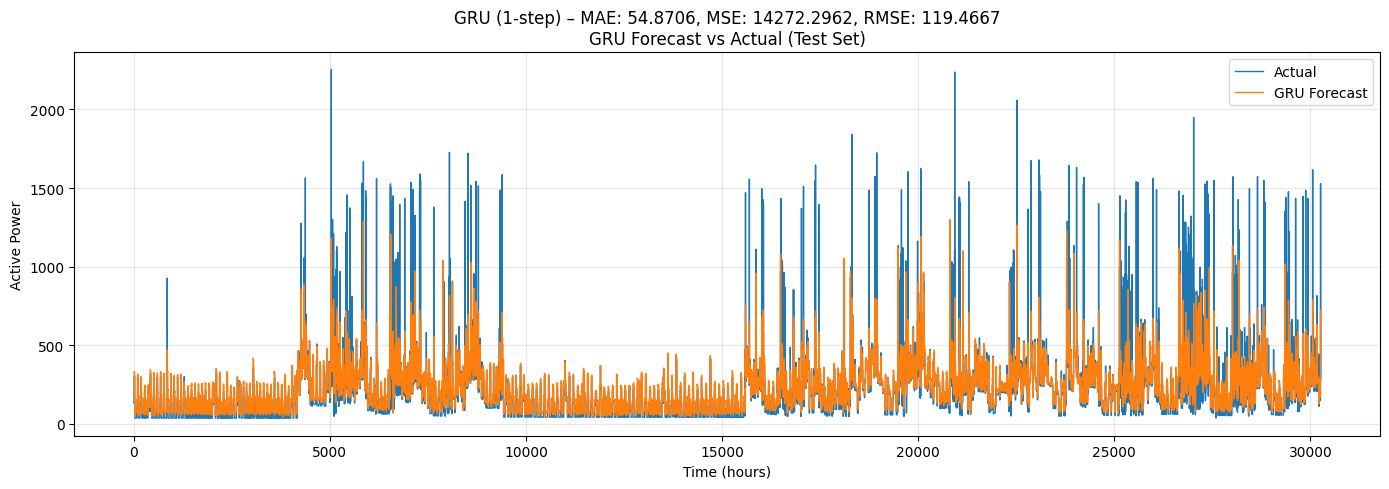

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y_test_inv_gru, label='Actual', linewidth=1)
plt.plot(y_pred_inv_gru, label='GRU Forecast', linewidth=1)
plt.title(
    f"GRU (1-step) – MAE: {mae_gru:.4f}, MSE: {mse_gru:.4f}, RMSE: {rmse_gru:.4f}\n"
    "GRU Forecast vs Actual (Test Set)"
)
plt.xlabel("Time (hours)")
plt.ylabel("Active Power")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


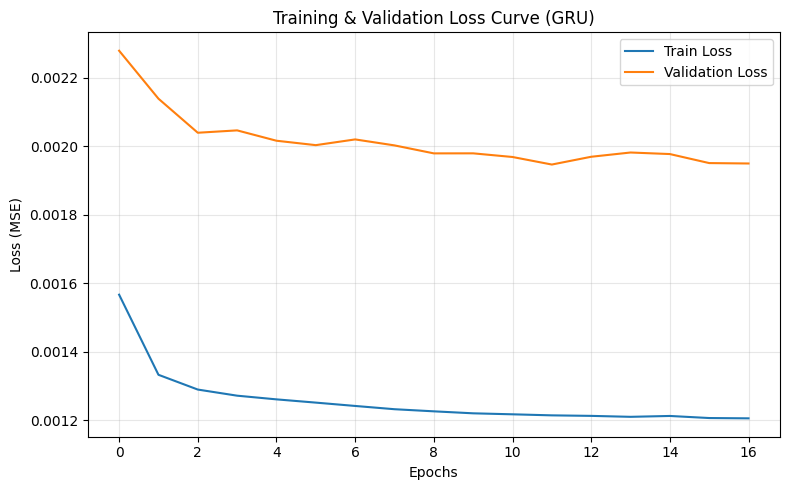

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss Curve (GRU)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
